Setup

In [1]:
#Reference Materials for the Code: ECO2425 Course Materials (Week 1-6 Python Notebooks)

In [ ]:
#You can find the LaTeX script here: https://www.overleaf.com/read/xfgzcnvfyvxy#241c12.

In [2]:
!pip uninstall -y numba numpy
!pip uninstall -y pygam
!pip install numpy==1.24.4 numba==0.57.1

Found existing installation: numba 0.57.1
Uninstalling numba-0.57.1:
  Successfully uninstalled numba-0.57.1
Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4
  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached numba-0.57.1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.7 kB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
Using cached numba-0.57.1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.6 MB)


In [3]:
!pip install l0bnb linearmodels matplotlib seaborn scikit-learn xgboost lightgbm -q


In [5]:
!pip install ISLP -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.57.1 requires numpy<1.25,>=1.21, but you have numpy 1.26.4 which is incompatible.


In [6]:
#Import Needed Packages
import numpy as np
import pandas as pd
import networkx as nx
import statsmodels.api as sm
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from l0bnb import fit_path
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)

from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)


I. Import Replication Dataset and Impose Same Filters

In [7]:
main_data = pd.read_stata("OG Full Dataset.dta")
restricted = main_data[(main_data['date']<=29) & (main_data['date']>=10) &
                       (main_data['gustav']>=1) & (main_data['dist_lib']>=-1) & 
                        (main_data['dist_lib']<=10)]

restricted.head(10)

year  month  date  cod_istat103  cod_prov103  cod_reg103  North  Center  \
5355  1944      6    18          1217            1           1      1       0   
5356  1944      6    18          1219            1           1      1       0   
5357  1944      6    18          1229            1           1      1       0   
5358  1944      6    18          1312            1           1      1       0   
5359  1944      6    18          1085            1           1      1       0   
5360  1944      6    18          1009            1           1      1       0   
5361  1944      6    18          1272            1           1      1       0   
5362  1944      6    18          1290            1           1      1       0   
5363  1944      6    18          1111            1           1      1       0   
5364  1944      6    18          1098            1           1      1       0   

      South  gustav  ...  p_voti2_liberali1924_miss  p_voti2_destra1924_miss  \
5355      0       1  ...                          1                        1   
5356      0       1  ...                          0                        0   
5357      0       1  ...                          0                        0   
5358      0       1  ...                          0                        0   
5359      0       1  ...                          0                        0   
5360      0       1  ...                          0                        0   
5361      0       1  ...                          0                        0   
5362      0       1  ...                          0                        0   
5363      0       1  ...                          0                        0   
5364      0       1  ...                          0                        0   

      p_voti2_cattolici1924_miss  p_voti2_socialisti1924_miss  \
5355                           1                            1   
5356                           0                            0   
5357                           0                            0   
5358                           0                            0   
5359                           0                            0   
5360                           0                            0   
5361                           0                            0   
5362                           0                            0   
5363                           0                            0   
5364                           0                            0   

      p_voti2_radicali1924_miss  p_voti2_repubblicani1924_miss  \
5355                          1                              1   
5356                          0                              0   
5357                          0                              0   
5358                          0                              0   
5359                          0                              0   
5360                          0                              0   
5361                          0                              0   
5362                          0                              0   
5363                          0                              0   
5364                          0                              0   

      p_voti2_fascisti1924_miss  p_voti2_comunisti1924_miss  \
5355                          1                           1   
5356                          0                           0   
5357                          0                           0   
5358                          0                           0   
5359                          0                           0   
5360                          0                           0   
5361                          0                           0   
5362                          0                           0   
5363                          0                           0   
5364                          0                           0   

      p_voti2_autonomisti1924_miss  p_voti2_altri1924_miss  
5355                             1 

In [8]:
#Rename dependant variables to something more intuitive
restricted = restricted.rename(columns = {"vict_rappr_aggr_AT_ep": "violence_episode_total", 
                                                          "vict_rappr_aggr_civ_AT_ep": "violence_episode_civilian_resistance", 
                                                          "vict_rappr_aggr_part_AT_ep": "violence_episode_partisan_resistance" })

     
#Rename controls to something more intuitive
restricted = restricted.rename(columns = {"MW_SNR": "BBC_SNR_Ratio",
                                         "rain": "avg_rainfall_millimeter",
                                         "cloud": "avg_cloud_coverage", 
                                         "temp": "avg_temperature"})

#Assign more intuitive names to the party variables
restricted.rename(columns=lambda x: x.replace('p_voti2_liberali', 'share_liberal') if 'p_voti2_liberali' in x else x, inplace=True)
restricted.rename(columns=lambda x: x.replace('p_voti2_socialisti', 'share_socialist') if 'p_voti2_socialisti' in x else x, inplace=True)
restricted.rename(columns=lambda x: x.replace('p_voti2_cattolici', 'share_catholic') if 'p_voti2_cattolici' in x else x, inplace=True)
restricted.rename(columns=lambda x: x.replace('p_voti2_comunisti', 'share_communist') if 'p_voti2_comunisti' in x else x, inplace=True)
restricted.rename(columns=lambda x: x.replace('p_voti2_fascisti', 'share_fascist') if 'p_voti2_fascisti' in x else x, inplace=True)
restricted.rename(columns=lambda x: x.replace('p_voti2_destra', 'share_conservative') if 'p_voti2_destra' in x else x, inplace=True)
restricted.rename(columns=lambda x: x.replace('p_voti2_autonomisti', 'share_independent') if 'p_voti2_autonomisti' in x else x, inplace=True)
restricted.rename(columns=lambda x: x.replace('p_voti2_altri', 'share_altri') if 'p_voti2_altri' in x else x, inplace=True)
restricted.rename(columns=lambda x: x.replace('p_voti2_radicali', 'share_radical') if 'p_voti2_radicali' in x else x, inplace=True)
restricted.rename(columns=lambda x: x.replace('p_voti2_repubblicani', 'share_republican') if 'p_voti2_repubblicani' in x else x, inplace=True)


#Restrict to the variables we need
restricted = restricted.loc[:, restricted.columns.str.contains('|'.join([ '1924', '1921', '1919', 'avg_cloud_coverage', 'avg_rainfall_millimeter', 
                                                                         'avg_temperature', 'BBC_SNR_Ratio', 'cod_istat103', 
                                                                         'violence_episode']))]
restricted = restricted.loc[:, ~restricted.columns.str.contains('_miss|_l01|_lgt1')]
print(restricted.columns.tolist())

['cod_istat103', 'violence_episode_total', 'violence_episode_civilian_resistance', 'violence_episode_partisan_resistance', 'BBC_SNR_Ratio', 'avg_rainfall_millimeter', 'avg_cloud_coverage', 'avg_temperature', 'share_liberal1919', 'share_conservative1919', 'share_catholic1919', 'share_socialist1919', 'share_radical1919', 'share_republican1919', 'share_fascist1919', 'share_communist1919', 'share_independent1919', 'share_altri1919', 'share_liberal1921', 'share_conservative1921', 'share_catholic1921', 'share_socialist1921', 'share_radical1921', 'share_republican1921', 'share_fascist1921', 'share_communist1921', 'share_independent1921', 'share_altri1921', 'share_liberal1924', 'share_conservative1924', 'share_catholic1924', 'share_socialist1924', 'share_radical1924', 'share_republican1924', 'share_fascist1924', 'share_communist1924', 'share_independent1924', 'share_altri1924']


II. Summary Statistics

In [9]:
#Aggregate the variables (to simple average)
collapse_columns = [col for col in restricted.columns if col != 'cod_istat103']
collapsed = restricted.groupby('cod_istat103')[collapse_columns].mean().reset_index()
#Drop NA-s 
collapsed = collapsed.replace([np.inf, -np.inf], np.nan).dropna()
collapsed.to_csv('collapsed_main.csv', index=False)

In [10]:
#Table 1:  Municipality-level 1919 Italian General Election Results
elec1919 = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1919']))]
summary19 = elec1919.describe()
summary19.to_csv('summary19.csv', index=False)


In [11]:
#Table 2:  Municipality-level 1921 Italian General Election Results
elec1921 = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1921']))]
summary21 = elec1921.describe()
summary21.to_csv('summary21.csv', index=False)

In [12]:
#Table 3:  Municipality-level 1924 Italian General Election Results
elec1924 = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1924']))]
summary24 = elec1924.describe()
summary24.to_csv('summary24.csv', index=False)

In [13]:
#Table 4: Average Monthly Number of Nazi Reprisals against Resistance
dep_sum = collapsed.loc[:, restricted.columns.str.contains('|'.join([ 'violence_episode']))]
dep_sum = dep_sum.describe()
dep_sum.to_csv('dep_sum.csv', index=False)

In [14]:
graph_names_1919 = {
    'share_liberal1919': 'Liberal Share (1919)',
    'share_radical1919': 'Far-Right Share (1919)',
    'share_socialist1919': 'Socialist Share (1919)',
    'share_republican1919': 'Republican Share (1919)',
    'share_conservative1919': 'Conservative Share (1919)',
    'share_catholic1919': 'Christian Share (1919)',
    'avg_cloud_coverage': 'Average Cloud Coverage',
    'avg_rainfall_millimeter': 'Average Rainfall (mm)',
    'avg_temperature': 'Average Temperature',
    'BBC_SNR_Ratio': 'BBC SNR Ratio'
}


In [15]:
graph_names_1921 = {
    'share_liberal1921': 'Liberal Share (1921)',
    'share_radical1921': 'Far-Right Share (1921)',
    'share_socialist1921': 'Socialist Share (1921)',
    'share_republican1921': 'Republican Share (1921)',
    'share_conservative1921': 'Conservative Share (1921)',
    'share_catholic1921': 'Christian Share (1921)',
    'share_fascist1921': 'Fascist Share (1921)',
    'share_communist1921': 'Communist Share (1921)',
    'share_independent1921': 'Independent Share (1921)',
    'share_altri1921': 'Other Parties Share (1921)',
    'avg_cloud_coverage': 'Average Cloud Coverage',
    'avg_rainfall_millimeter': 'Average Rainfall (mm)',
    'avg_temperature': 'Average Temperature',
    'BBC_SNR_Ratio': 'BBC SNR Ratio'
}

In [16]:
graph_names_1924 = {
    'share_liberal1924': 'Liberal Share (1924)',
    'share_radical1924': 'Far-Right Share (1924)',
    'share_socialist1924': 'Socialist Share (1924)',
    'share_republican1924': 'Republican Share (1924)',
    'share_conservative1924': 'Conservative Share (1924)',
    'share_catholic1924': 'Christian Share (1924)',
    'share_fascist1924': 'Fascist Share (1924)',
    'share_communist1924': 'Communist Share (1924)',
    'share_independent1924': 'Independent Share (1924)',
    'avg_cloud_coverage': 'Average Cloud Coverage',
    'avg_rainfall_millimeter': 'Average Rainfall (mm)',
    'avg_temperature': 'Average Temperature',
    'BBC_SNR_Ratio': 'BBC SNR Ratio'
}

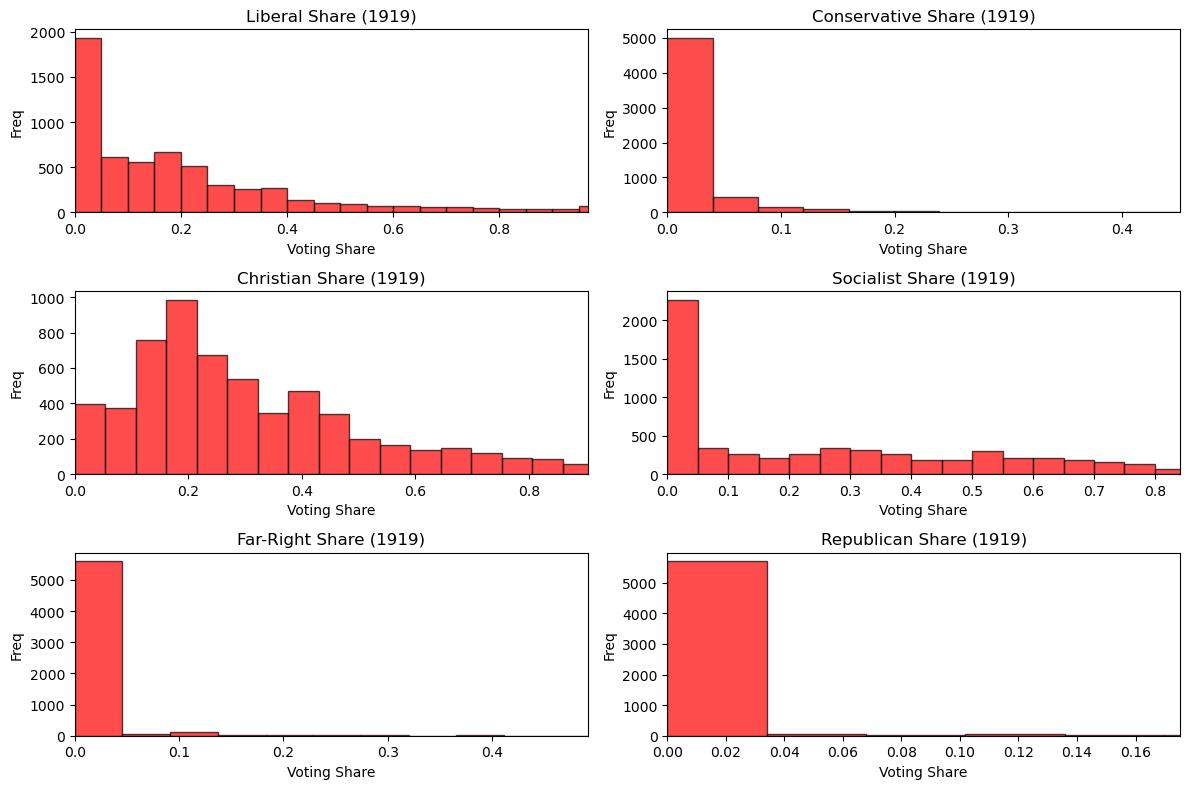

In [17]:
#Figure A.1: Municipality-level Voting Shares in 1919 
f, yx = plt.subplots(3, 2, figsize=(12, 8))
yx = yx.flatten()

elec1919hist = elec1919.loc[:, ~elec1919.columns.str.contains('|'.join([ 'share_fascist', 'share_communist', 'share_independent', 'share_altri']))]

for party, column in enumerate(elec1919hist.columns):
    yx_mod = yx[party]  
    yx_mod.hist(elec1919hist[column], bins=20, alpha=0.7, color='red', edgecolor='black')
    yx_mod.set_title(graph_names_1919.get(column, column))
    yx_mod.set_xlabel('Voting Share')
    yx_mod.set_ylabel('Freq')
    yx_mod.set_xlim(elec1919hist[column].min(), elec1919hist[column].quantile(0.99))

for i in range(len(elec1919hist.columns), len(yx)):
    f.delaxes(yx_mod[i])

plt.tight_layout()
plt.show()

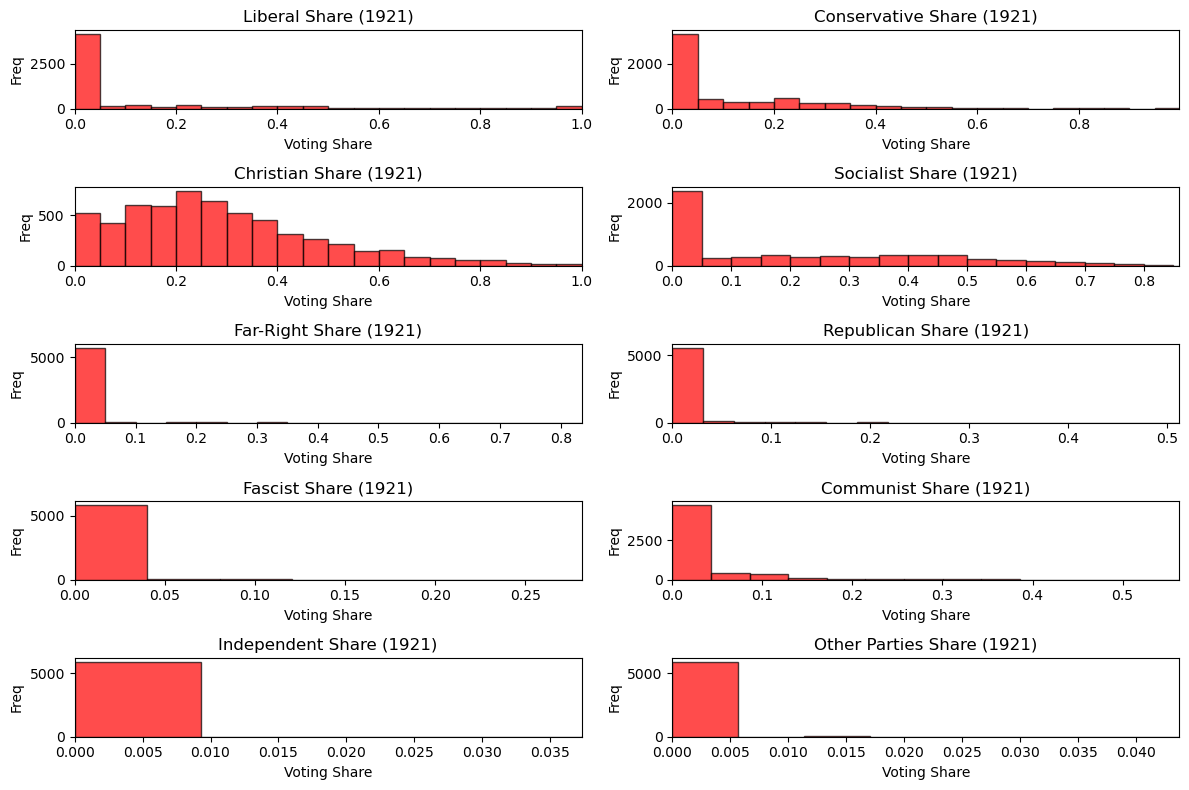

In [18]:
#Figure A.2: Municipality-level Voting Shares in 1921
f, yx = plt.subplots(5, 2, figsize=(12, 8))
yx = yx.flatten()

for party, column in enumerate(elec1921.columns):
    yx_mod = yx[party]  
    yx_mod.hist(elec1921[column], bins=20, alpha=0.7, color='red', edgecolor='black')
    yx_mod.set_title(graph_names_1921.get(column, column))
    yx_mod.set_xlabel('Voting Share')
    yx_mod.set_ylabel('Freq')
    yx_mod.set_xlim(elec1921[column].min(), elec1921[column].quantile(0.999))
    
for i in range(len(elec1921.columns), len(yx)):
    f.delaxes(yx_mod[i])

plt.tight_layout()
plt.show()

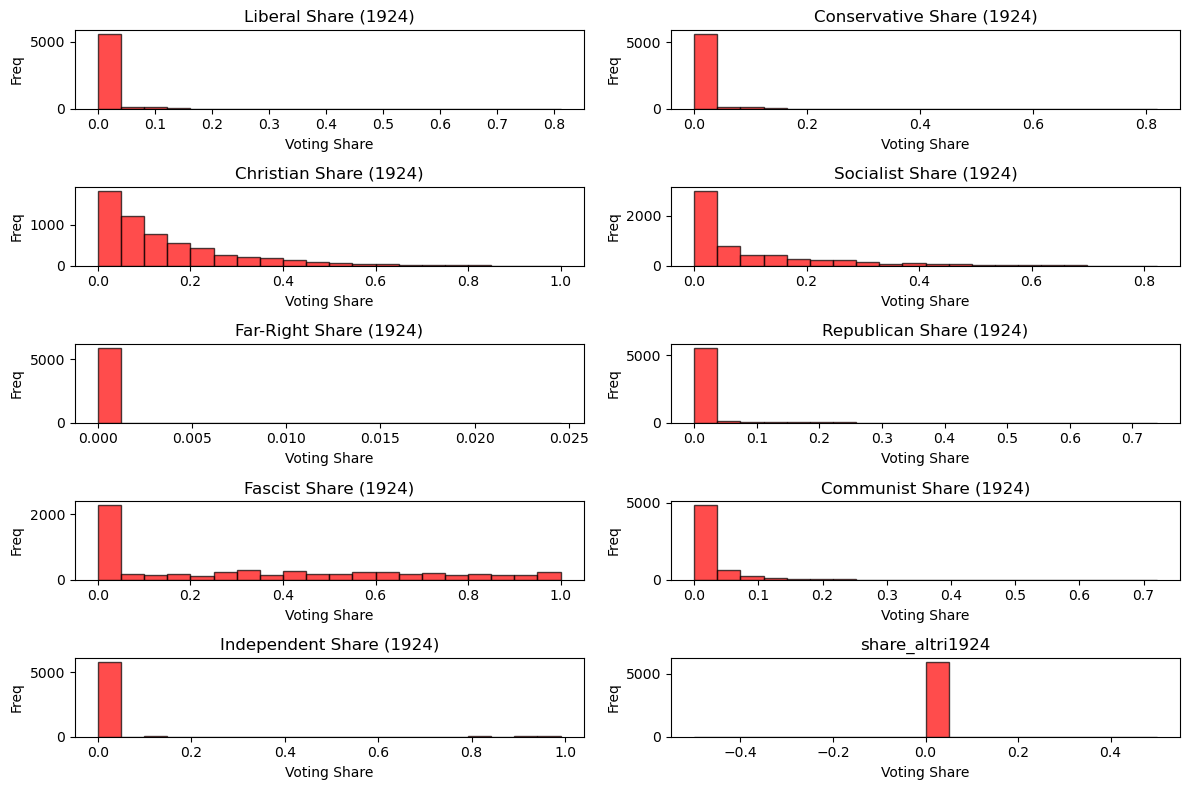

In [19]:
#Figure A.3: Municipality-level Voting Shares in 1924
f, yx = plt.subplots(5, 2, figsize=(12, 8))
yx = yx.flatten()

for party, column in enumerate(elec1924.columns):
    yx_mod = yx[party]  
    yx_mod.hist(elec1924[column], bins=20, alpha=0.7, color='red', edgecolor='black')
    yx_mod.set_title(graph_names_1924.get(column, column))
    yx_mod.set_xlabel('Voting Share')
    yx_mod.set_ylabel('Freq')

for i in range(len(elec1924.columns), len(yx)):
    f.delaxes(yx_mod[i])

plt.tight_layout()
plt.show()

III. DAG Graph

In [20]:
#Prepare set-up for GML Graph
my_gml = """graph [
directed 1

node [
    id 3
    label "Party Vote %"
    ]

node [
    id 1
    label "Mean(Reprisals)"
    ]
  
node [
    id 2
    label "Control: weather"
]


node [
    id 0
    label "Control: radio"
]

edge [
    source 0
    target 1
    ]
    
edge [
    source 2
    target 1
    ]
    
    edge [
    source 3
    target 1
    ]
    
    
    edge [
    source 0
    target 3
    ]
    
       edge [
    source 2
    target 3
    ]
    
    
]
    
    """

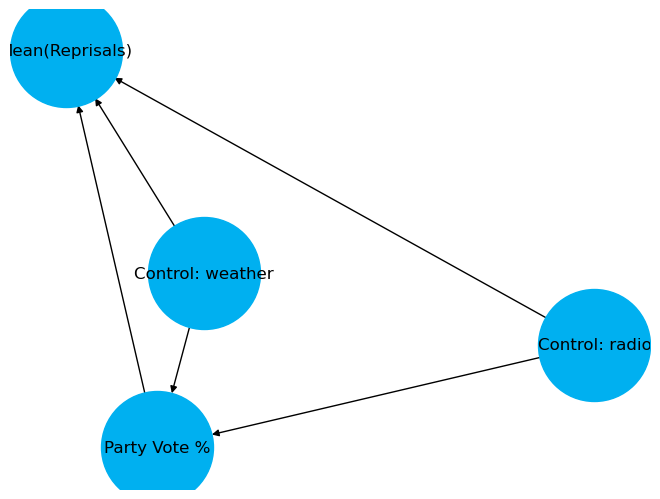

In [21]:
#Figure 1: Directed Acyclic Graph of the Main Model
graph = nx.parse_gml(my_gml)

nx.draw(
    G=graph, 
    with_labels=True,
    node_size=6500,
    node_color=[
    '#00B0F0',
    '#FF0000'
][0],
    font_color='black'
)

IV. Regression Model

In [22]:
#Table 5:  OLS Regression using 1919 Election Results
x = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1919',  'avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 'BBC_SNR_Ratio']))]
y = collapsed['violence_episode_total']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())
latex_output = model.summary().as_latex ()
print(latex_output)

                              OLS Regression Results                              
Dep. Variable:     violence_episode_total   R-squared:                       0.091
Model:                                OLS   Adj. R-squared:                  0.089
Method:                     Least Squares   F-statistic:                     58.82
Date:                    Thu, 31 Oct 2024   Prob (F-statistic):          3.76e-114
Time:                            16:13:59   Log-Likelihood:                -3049.3
No. Observations:                    5921   AIC:                             6121.
Df Residuals:                        5910   BIC:                             6194.
Df Model:                              10                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

/opt/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [23]:
#Table 5:  OLS Regression using 1921 Election Results
x = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1921',  'avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 'BBC_SNR_Ratio']))]
y = collapsed['violence_episode_total']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())
latex_output = model.summary().as_latex ()
print(latex_output)

                              OLS Regression Results                              
Dep. Variable:     violence_episode_total   R-squared:                       0.090
Model:                                OLS   Adj. R-squared:                  0.088
Method:                     Least Squares   F-statistic:                     41.77
Date:                    Thu, 31 Oct 2024   Prob (F-statistic):          4.18e-110
Time:                            16:14:00   Log-Likelihood:                -3050.7
No. Observations:                    5921   AIC:                             6131.
Df Residuals:                        5906   BIC:                             6232.
Df Model:                              14                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [24]:
#Table 5:  OLS Regression using 1924 Election Results
x = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1924',  'avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 'BBC_SNR_Ratio']))]
y = collapsed['violence_episode_total']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())
latex_output = model.summary().as_latex ()
print(latex_output)

                              OLS Regression Results                              
Dep. Variable:     violence_episode_total   R-squared:                       0.088
Model:                                OLS   Adj. R-squared:                  0.086
Method:                     Least Squares   F-statistic:                     44.08
Date:                    Thu, 31 Oct 2024   Prob (F-statistic):          1.24e-108
Time:                            16:14:00   Log-Likelihood:                -3056.1
No. Observations:                    5921   AIC:                             6140.
Df Residuals:                        5907   BIC:                             6234.
Df Model:                              13                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

/opt/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


V. Random Forest Model

In [25]:
#Table 6: Importance Matrix for Random Forest (1919 Election Results)
x = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1919',  'avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 'BBC_SNR_Ratio']))]
y = collapsed['violence_episode_total']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=55)
rf_model = RandomForestRegressor(
    n_estimators=1000,  
    max_depth=5,       
    random_state=55   
)
rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE (1919): {mse}')

r2 = r2_score(y_test, y_pred)
print(f'R-squared (1919): {r2}')

importance_matrix = rf_model.feature_importances_
importance_for_graph = pd.DataFrame({
    'Variable': x.columns,
    'Importance': importance_matrix
}).sort_values(by='Importance', ascending=False)

print(importance_for_graph)

MSE (1919): 0.11711704295148484
R-squared (1919): 0.15197046226864697
                   Variable  Importance
3           avg_temperature    0.282995
1   avg_rainfall_millimeter    0.221715
6        share_catholic1919    0.198952
0             BBC_SNR_Ratio    0.136680
2        avg_cloud_coverage    0.057404
4         share_liberal1919    0.041225
8         share_radical1919    0.040672
7       share_socialist1919    0.009871
9      share_republican1919    0.005486
5    share_conservative1919    0.005000
10        share_fascist1919    0.000000
11      share_communist1919    0.000000
12    share_independent1919    0.000000
13          share_altri1919    0.000000


In [26]:
#Table 8: Importance Matrix for Random Forest (1921 Election Results)

x = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1921',  'avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 'BBC_SNR_Ratio']))]
y = collapsed['violence_episode_total']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=55)
rf_model = RandomForestRegressor(
    n_estimators=1000,  
    max_depth=5,       
    random_state=55   
)
rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE (1921): {mse}')

r2 = r2_score(y_test, y_pred)
print(f'R-squared (1921): {r2}')

importance_matrix = rf_model.feature_importances_
importance_for_graph = pd.DataFrame({
    'Variable': x.columns,
    'Importance': importance_matrix
}).sort_values(by='Importance', ascending=False)

print(importance_for_graph)


MSE (1921): 0.12403026506153503
R-squared (1921): 0.1019127046402496
                   Variable  Importance
3           avg_temperature    0.285430
1   avg_rainfall_millimeter    0.178793
4         share_liberal1921    0.157536
6        share_catholic1921    0.118436
0             BBC_SNR_Ratio    0.102656
2        avg_cloud_coverage    0.052902
7       share_socialist1921    0.048016
8         share_radical1921    0.044412
9      share_republican1921    0.006017
11      share_communist1921    0.004783
5    share_conservative1921    0.000816
13          share_altri1921    0.000201
10        share_fascist1921    0.000003
12    share_independent1921    0.000000


In [27]:
#Table 10: Importance Matrix for Random Forest (1924 Election Results)

x = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1924',  'avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 'BBC_SNR_Ratio']))]
y = collapsed['violence_episode_total']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=55)
rf_model = RandomForestRegressor(
    n_estimators=1000,  
    max_depth=5,       
    random_state=55   
)
rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE (1924): {mse}')

r2 = r2_score(y_test, y_pred)
print(f'R-squared (1924): {r2}')

importance_matrix = rf_model.feature_importances_
importance_for_graph = pd.DataFrame({
    'Variable': x.columns,
    'Importance': importance_matrix
}).sort_values(by='Importance', ascending=False)

print(importance_for_graph)

MSE (1924): 0.13168503275560475
R-squared (1924): 0.0464855102247288
                   Variable  Importance
3           avg_temperature    0.346444
1   avg_rainfall_millimeter    0.304301
0             BBC_SNR_Ratio    0.181412
2        avg_cloud_coverage    0.090037
6        share_catholic1924    0.070412
7       share_socialist1924    0.003112
11      share_communist1924    0.001462
4         share_liberal1924    0.001211
9      share_republican1924    0.000802
10        share_fascist1924    0.000469
8         share_radical1924    0.000325
5    share_conservative1924    0.000007
12    share_independent1924    0.000006
13          share_altri1924    0.000000


VI. Robustness Checks

In [28]:
#Table 12: OLS Model Cross-Validation Results - 1919
x = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1919',  'avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 'BBC_SNR_Ratio']))]
y = collapsed['violence_episode_total']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=55)
ols_model = skl.LinearRegression()
cv = skm.cross_val_score(ols_model, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
mean_cv_mse = -cv.mean()
print(f'Mean CV MSE (1919): {mean_cv_mse}')
ols_model.fit(x_train, y_train)
y_pred = ols_model.predict(x_test)
test_mse = mean_squared_error(y_test, y_pred)
print(f'Test MSE (1919): {test_mse}')
     
test_r2 = r2_score(y_test, y_pred)
print(f'R-squared (1919): {test_r2}')

Mean CV MSE (1919): 0.18010991220107161
Test MSE (1919): 0.12070633755174119
R-squared (1919): 0.12598083886347


In [29]:
#Table 12: OLS Model Cross-Validation Results - 1921
x = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1921',  'avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 'BBC_SNR_Ratio']))]
y = collapsed['violence_episode_total']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=55)
ols_model = skl.LinearRegression()
cv = skm.cross_val_score(ols_model, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
mean_cv_mse = -cv.mean()
print(f'Mean CV MSE (1921): {mean_cv_mse}')

ols_model.fit(x_train, y_train)
y_pred = ols_model.predict(x_test)
test_mse = mean_squared_error(y_test, y_pred)
print(f'Test MSE (1921): {test_mse}')
      
test_r2 = r2_score(y_test, y_pred)
print(f'R-squared (1921): {test_r2}')
  

Mean CV MSE (1921): 0.18194179236414026
Test MSE (1921): 0.12223865909515182
R-squared (1921): 0.11488549443394391


In [30]:
#Table 12: OLS Model Cross-Validation Results - 1924
x = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1924',  'avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 'BBC_SNR_Ratio']))]
y = collapsed['violence_episode_total']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=55)
ols_model = skl.LinearRegression()
cv = skm.cross_val_score(ols_model, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
mean_cv_mse = -cv.mean()
print(f'Mean CV MSE (1924): {mean_cv_mse}')

ols_model.fit(x_train, y_train)
y_pred = ols_model.predict(x_test)
test_mse = mean_squared_error(y_test, y_pred)
print(f'Test MSE (1924): {test_mse}')


test_r2 = r2_score(y_test, y_pred)
print(f'R-squared (1924): {test_r2}')

Mean CV MSE (1924): 0.17979471589816867
Test MSE (1924): 0.12211237429760845
R-squared (1924): 0.11579990651082306


In [31]:
#Table 13: Importance Matrix for Gradient Boosting - 1919
x = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1919',  'avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 'BBC_SNR_Ratio']))]
y = collapsed['violence_episode_total']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=55)
boosting_model = GradientBoostingRegressor(
    n_estimators=1000,
    learning_rate = 0.1,
    max_depth=5,       
    random_state=55   
)

boosting_model.fit(x_train, y_train)
y_pred = boosting_model.predict(x_test)
print(f'MSE (1919): {mse}')

mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
print(f'R-squared (1919): {r2}')

boosting_imp = boosting_model.feature_importances_
importance_matrix = pd.DataFrame({'Variable': x.columns, 'Importance': boosting_imp})
importance_matrix = importance_matrix.sort_values(by='Importance', ascending=False)
print(importance_matrix)

MSE (1919): 0.13168503275560475
R-squared (1919): 0.0464855102247288
                   Variable  Importance
3           avg_temperature    0.224650
6        share_catholic1919    0.222691
1   avg_rainfall_millimeter    0.213826
0             BBC_SNR_Ratio    0.140858
2        avg_cloud_coverage    0.063401
4         share_liberal1919    0.052024
8         share_radical1919    0.042717
7       share_socialist1919    0.025440
5    share_conservative1919    0.007253
9      share_republican1919    0.007141
10        share_fascist1919    0.000000
11      share_communist1919    0.000000
12    share_independent1919    0.000000
13          share_altri1919    0.000000


In [32]:
#Table 13: Importance Matrix for Gradient Boosting - 1921
x = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1921',  'avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 'BBC_SNR_Ratio']))]
y = collapsed['violence_episode_total']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=55)
boosting_model = GradientBoostingRegressor(
    n_estimators=1000,
    learning_rate = 0.1,
    max_depth=5,       
    random_state=55   
)

boosting_model.fit(x_train, y_train)
y_pred = boosting_model.predict(x_test)
print(f'MSE (1921): {mse}')

mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
print(f'R-squared (1921): {r2}')

boosting_imp = boosting_model.feature_importances_
importance_matrix = pd.DataFrame({'Variable': x.columns, 'Importance': boosting_imp})
importance_matrix = importance_matrix.sort_values(by='Importance', ascending=False)
print(importance_matrix)

MSE (1921): 0.12896106268187052
R-squared (1921): 0.0464855102247288
                   Variable  Importance
3           avg_temperature    0.229151
4         share_liberal1921    0.217230
1   avg_rainfall_millimeter    0.129769
0             BBC_SNR_Ratio    0.124332
6        share_catholic1921    0.107610
2        avg_cloud_coverage    0.067367
7       share_socialist1921    0.065076
8         share_radical1921    0.031098
9      share_republican1921    0.011566
5    share_conservative1921    0.008957
11      share_communist1921    0.005407
13          share_altri1921    0.001784
10        share_fascist1921    0.000516
12    share_independent1921    0.000137


In [34]:
#Table 13: Importance Matrix for Gradient Boosting - 1924
x = collapsed.loc[:, restricted.columns.str.contains('|'.join([ '1924',  'avg_cloud_coverage', 'avg_rainfall_millimeter', 'avg_temperature', 'BBC_SNR_Ratio']))]
y = collapsed['violence_episode_total']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=55)
boosting_model = GradientBoostingRegressor(
    n_estimators=1000,
    learning_rate = 0.1,
    max_depth=5,       
    random_state=55   
)

boosting_model.fit(x_train, y_train)
y_pred = boosting_model.predict(x_test)
print(f'MSE (1924): {mse}')

mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
print(f'R-squared (1924): {r2}')

boosting_imp = boosting_model.feature_importances_
importance_matrix = pd.DataFrame({'Variable': x.columns, 'Importance': boosting_imp})
importance_matrix = importance_matrix.sort_values(by='Importance', ascending=False)
print(importance_matrix)

MSE (1924): 0.14983869819788745
R-squared (1924): 0.0464855102247288
                   Variable  Importance
3           avg_temperature    0.291375
1   avg_rainfall_millimeter    0.259345
0             BBC_SNR_Ratio    0.220387
2        avg_cloud_coverage    0.107572
6        share_catholic1924    0.066739
9      share_republican1924    0.012480
11      share_communist1924    0.012436
4         share_liberal1924    0.010079
7       share_socialist1924    0.009366
10        share_fascist1924    0.007586
12    share_independent1924    0.001162
8         share_radical1924    0.000943
5    share_conservative1924    0.000528
13          share_altri1924    0.000000


VII. Ridge & Decision Tree

In [35]:
#Set up data for Ridge regression and fit the model - 1924
collapsed_1924 = collapsed.loc[:, collapsed.columns.str.contains('|'.join(['1924', 'avg_cloud_coverage', 'avg_rainfall_millimeter', 
                                                                         'avg_temperature', 'BBC_SNR_Ratio', 
                                                                         'violence_episode_total']))]
collapsed_1924 = collapsed_1924.loc[:, ~collapsed_1924.columns.str.contains('|'.join(['share_altri1924']))]
design = MS(collapsed_1924.columns.drop('violence_episode_total')).fit(collapsed_1924)
Y = np.array(collapsed_1924['violence_episode_total'])
D = design.fit_transform(collapsed_1924)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

Xs = X - X.mean(0)[None,:]

X_scale = X.std(0)

X_scale_nonzero = np.where(X_scale == 0, 1e-10, X_scale)

Xs = Xs / X_scale_nonzero[None, :]
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs,
                                 Y,
                                 l1_ratio=0.,
                                 alphas=lambdas)[1]
soln_array.shape

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 552.1889038085938, tolerance: 0.1104377806186676
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent w

(13, 100)

/tmp/ipykernel_70/1484684256.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap("tab20")


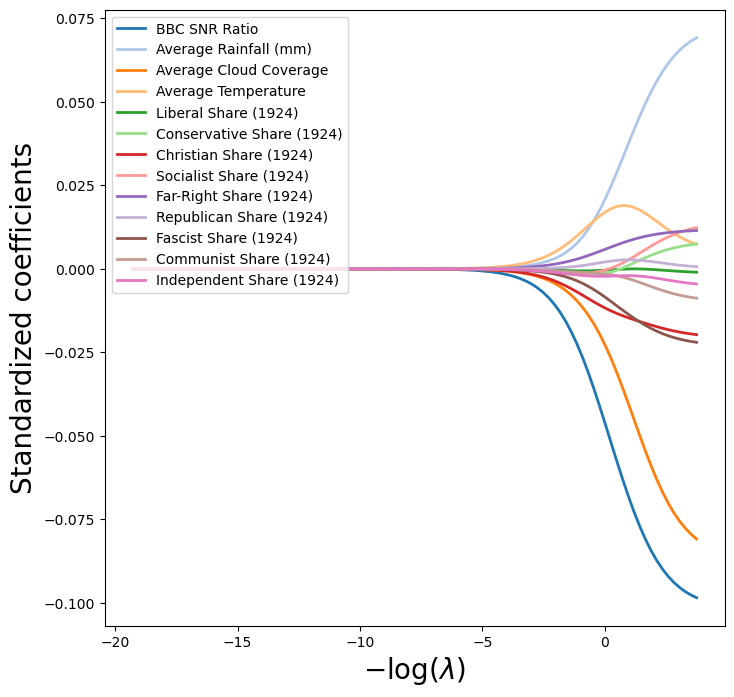

In [36]:
#Figure 10: Ridge Regression Coefficients for 1919
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

soln_path.rename(columns=graph_names_1924, inplace=True)

path_fig, ax = subplots(figsize=(8,8))
colormap = get_cmap("tab20")
for i, column in enumerate(soln_path.columns):
    soln_path[column].plot(ax=ax, color=colormap(i % 20), linewidth=2, label=column)

#soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left');

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.337e+02, tolerance: 1.068e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.866e+02, tolerance: 6.411e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

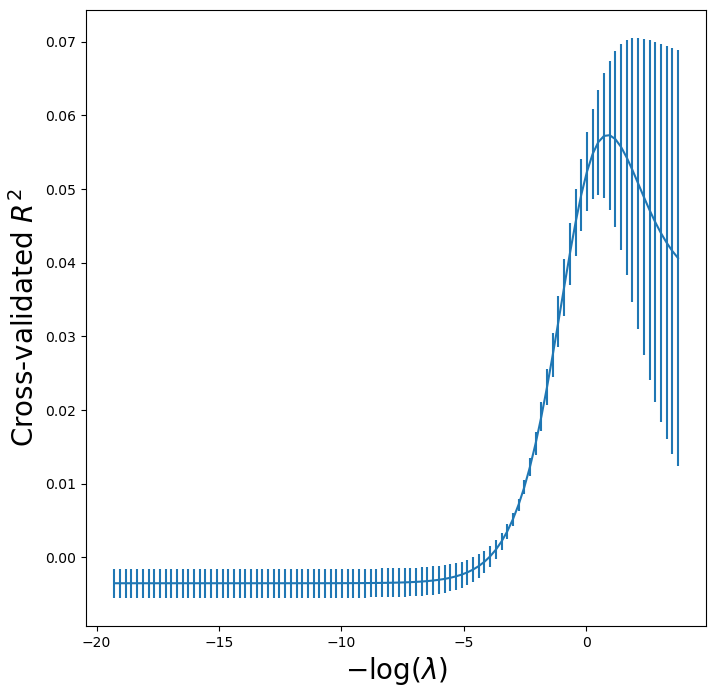

In [37]:
#Figure A.11: Ridge CV Plot for 1924
beta_hat = soln_path.loc[soln_path.index[39]]
lambdas[39], beta_hat
np.linalg.norm(beta_hat)
beta_hat = soln_path.loc[soln_path.index[59]]
lambdas[59], np.linalg.norm(beta_hat)
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True,  with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=0.5,
                              random_state=0)
ridge.alpha = 0.01
results = skm.cross_validate(ridge,
                             X,
                             Y,
                             scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)
param_grid = {'ridge__alpha': lambdas}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=validation,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_


grid_r2 = skm.GridSearchCV(pipe,
                           param_grid,
                           cv=kfold)
grid_r2.fit(X, Y)

r2_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            grid_r2.cv_results_['mean_test_score'],
            yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated $R^2$', fontsize=20);

/tmp/ipykernel_70/3544775889.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap("tab20")


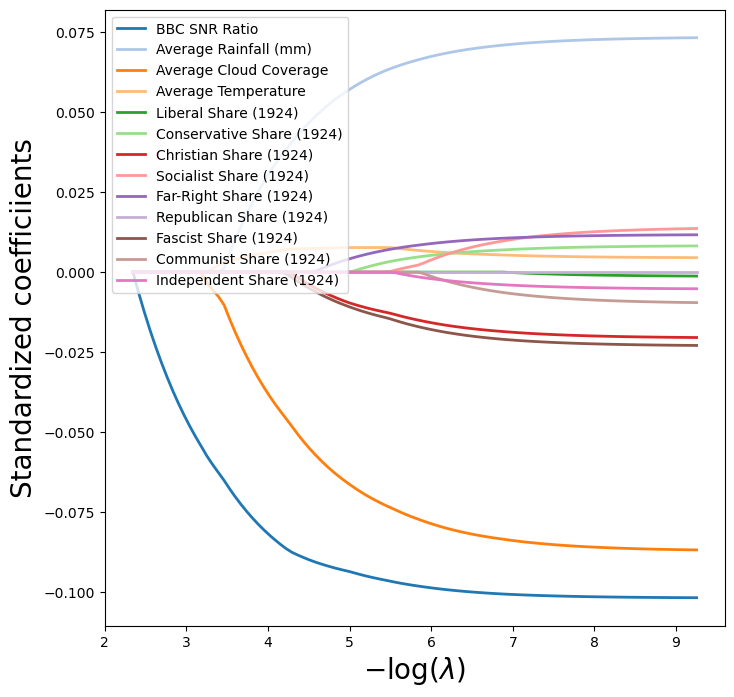

In [39]:
#Figure A.12: Lasso 1924 
lassoCV = skl.ElasticNetCV(n_alphas=100,
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_
lambdas, soln_array = skl.Lasso.path(Xs,
                                    Y,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

soln_path.rename(columns=graph_names_1924, inplace=True)

path_fig, ax = subplots(figsize=(8,8))
colormap = get_cmap("tab20")
for i, column in enumerate(soln_path.columns):
    soln_path[column].plot(ax=ax, color=colormap(i % 20), linewidth=2, label=column)

ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);


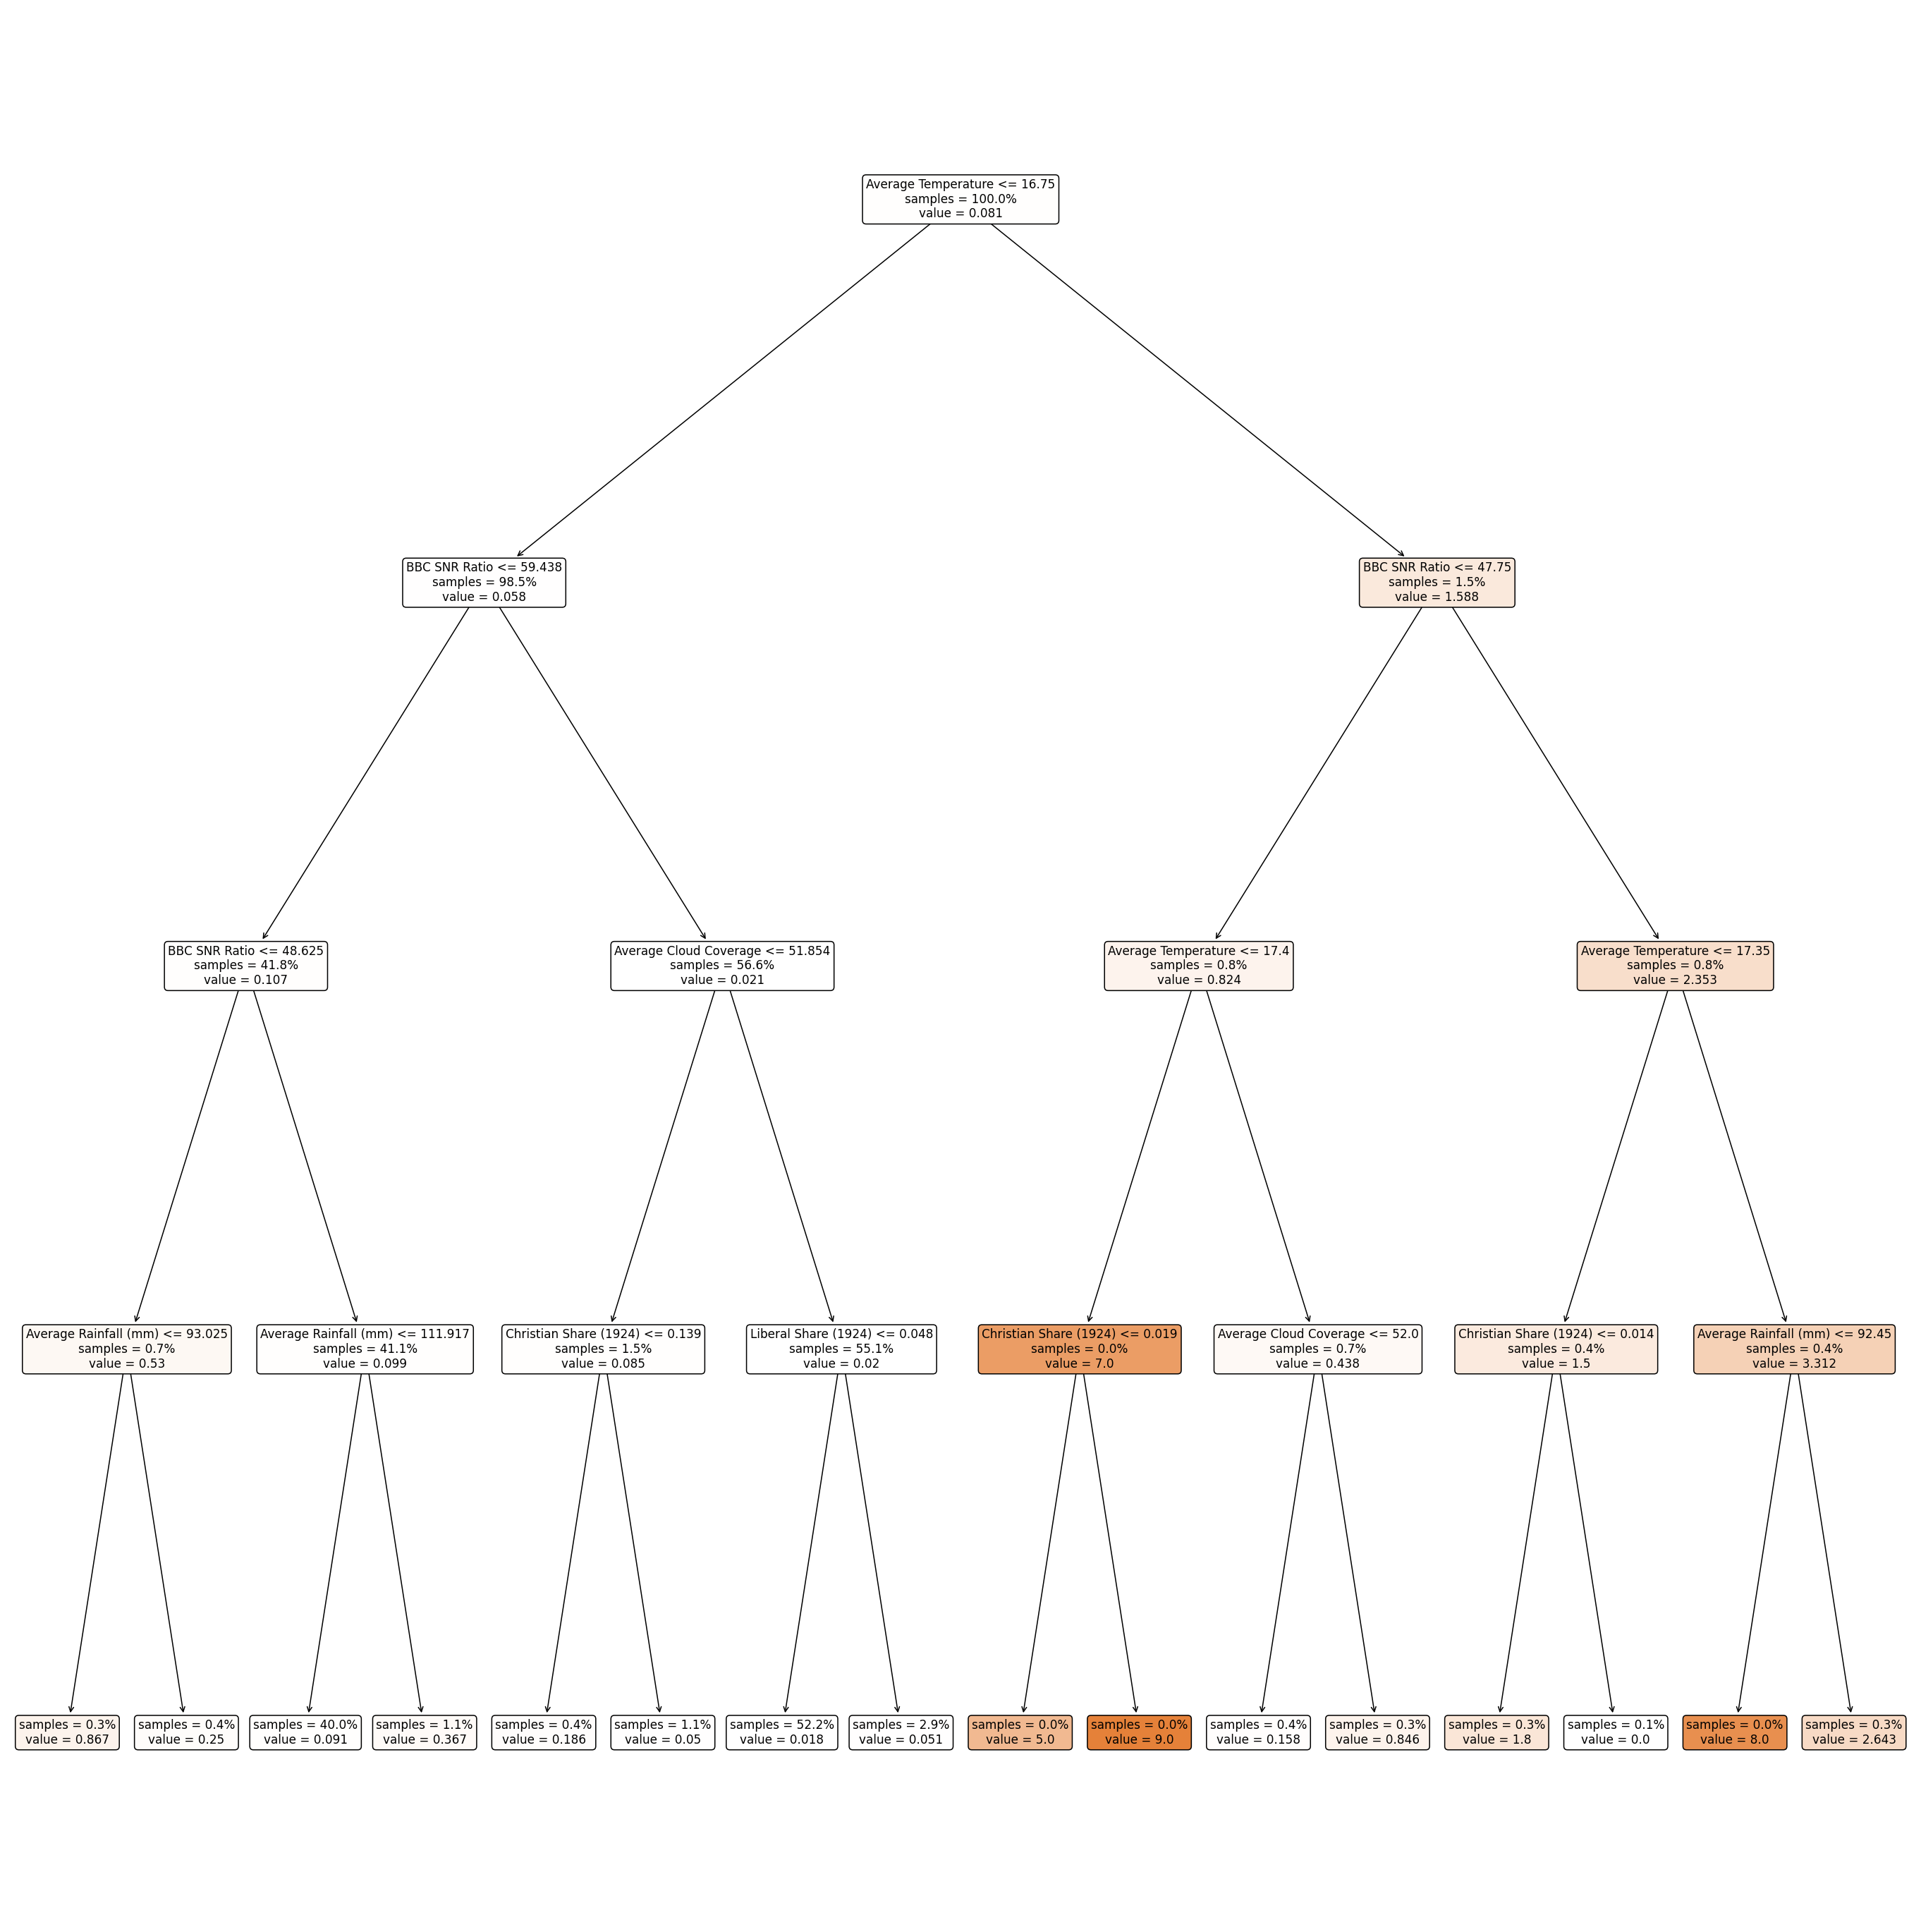

In [41]:
#Figure A.6: Single Decision Tree - 1924
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                collapsed_1924['violence_episode_total'],
                                test_size=0.25,
                                random_state=0)


reg = DTR(max_depth=4)
reg.fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(25, 25), dpi=110)

feature_names = [graph_names_1924.get(name, name) for name in D.columns]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax,
          filled=True, 
         rounded=True,
         proportion=True, 
          impurity=False,
          fontsize=11);
plt.tight_layout()   

In [42]:
#Set up data for Ridge regression and fit the model - 1921
collapsed_1921 = collapsed.loc[:, collapsed.columns.str.contains('|'.join([ '1921', 'avg_cloud_coverage', 'avg_rainfall_millimeter', 
                                                                         'avg_temperature', 'BBC_SNR_Ratio', 
                                                                         'violence_episode_total']))]
design = MS(collapsed_1921.columns.drop('violence_episode_total')).fit(collapsed_1921)
Y = np.array(collapsed_1921['violence_episode_total'])
D = design.fit_transform(collapsed_1921)
D = D.drop('intercept', axis=1)
X = np.asarray(D)


Xs = X - X.mean(0)[None,:]

X_scale = X.std(0)

X_scale_nonzero = np.where(X_scale == 0, 1e-10, X_scale)

Xs = Xs / X_scale_nonzero[None, :]
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs,
                                 Y,
                                 l1_ratio=0.,
                                 alphas=lambdas)[1]
soln_array.shape


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 552.1889038085938, tolerance: 0.1104377806186676
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent w

(14, 100)

/tmp/ipykernel_70/1582600089.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap("tab20")


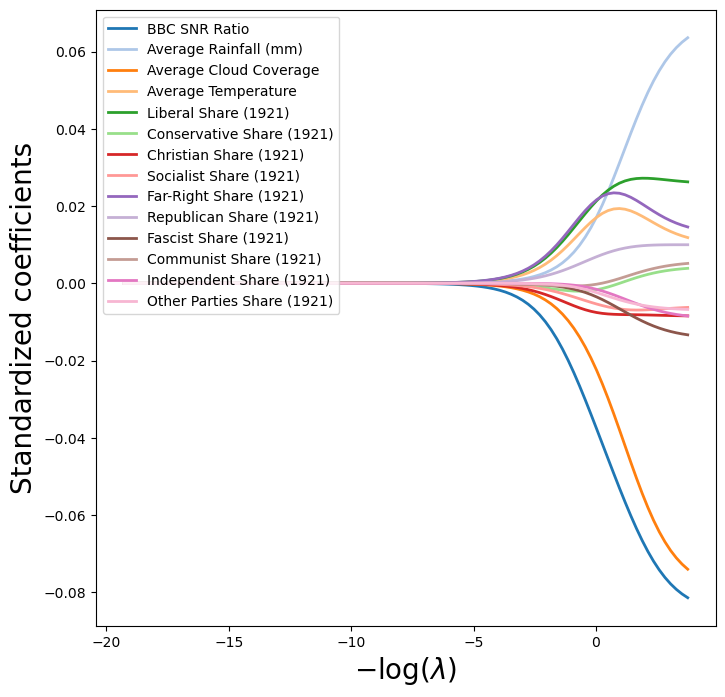

In [43]:
#Figure 8: Ridge Regression Coefficients for 1921
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path


soln_path.rename(columns=graph_names_1921, inplace=True)


path_fig, ax = subplots(figsize=(8,8))
colormap = get_cmap("tab20")
for i, column in enumerate(soln_path.columns):
    soln_path[column].plot(ax=ax, color=colormap(i % 20), linewidth=2, label=column)

ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left');

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.336e+02, tolerance: 1.068e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.868e+02, tolerance: 6.411e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

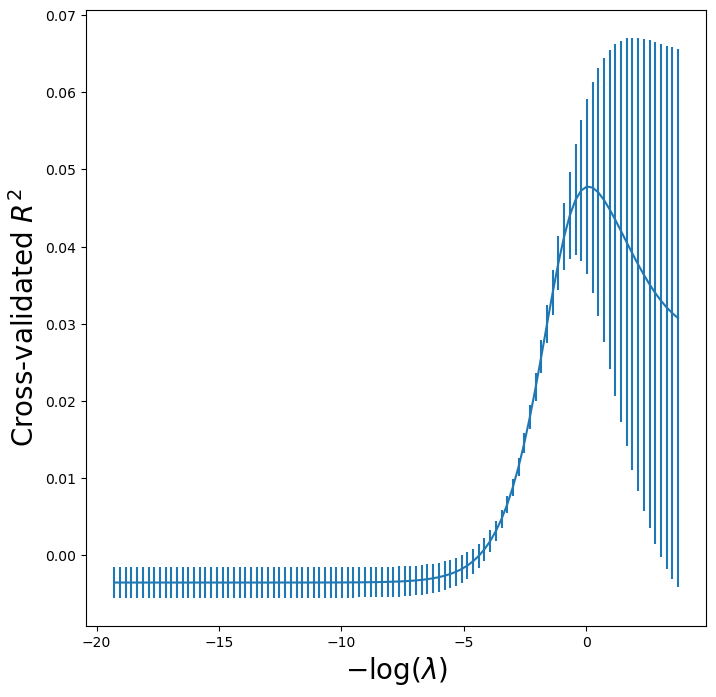

In [44]:
#Figure A.9: Ridge CV Plot for 1921 Elections
beta_hat = soln_path.loc[soln_path.index[39]]
lambdas[39], beta_hat
np.linalg.norm(beta_hat)
beta_hat = soln_path.loc[soln_path.index[59]]
lambdas[59], np.linalg.norm(beta_hat)
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True,  with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=0.5,
                              random_state=0)
ridge.alpha = 0.01
results = skm.cross_validate(ridge,
                             X,
                             Y,
                             scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)
param_grid = {'ridge__alpha': lambdas}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=validation,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_


grid_r2 = skm.GridSearchCV(pipe,
                           param_grid,
                           cv=kfold)
grid_r2.fit(X, Y)

r2_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            grid_r2.cv_results_['mean_test_score'],
            yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated $R^2$', fontsize=20);


/tmp/ipykernel_70/4291048091.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap("tab20")


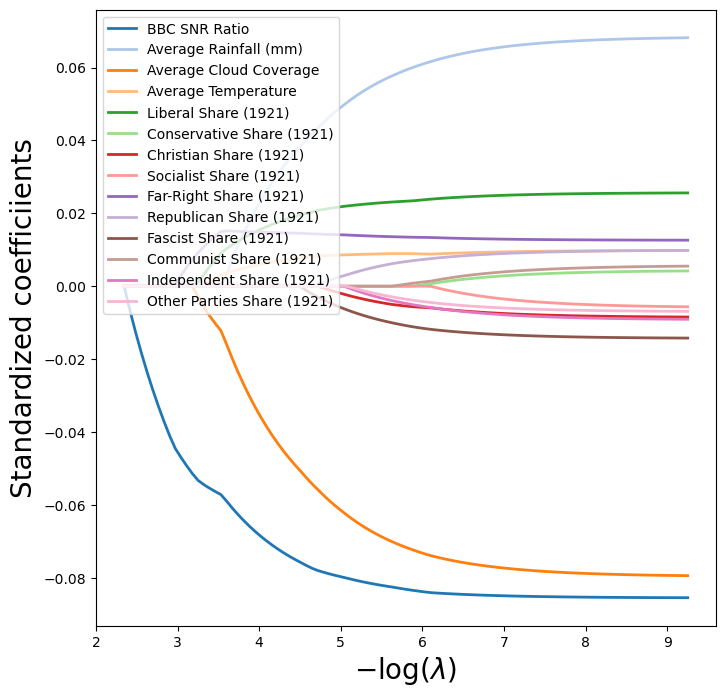

In [45]:
#Figure A.10: Lasso for 1921 elections 

lassoCV = skl.ElasticNetCV(n_alphas=100,
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_
lambdas, soln_array = skl.Lasso.path(Xs,
                                    Y,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

soln_path.rename(columns=graph_names_1921, inplace=True)

path_fig, ax = subplots(figsize=(8,8))
colormap = get_cmap("tab20")
for i, column in enumerate(soln_path.columns):
    soln_path[column].plot(ax=ax, color=colormap(i % 20), linewidth=2, label=column)

ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

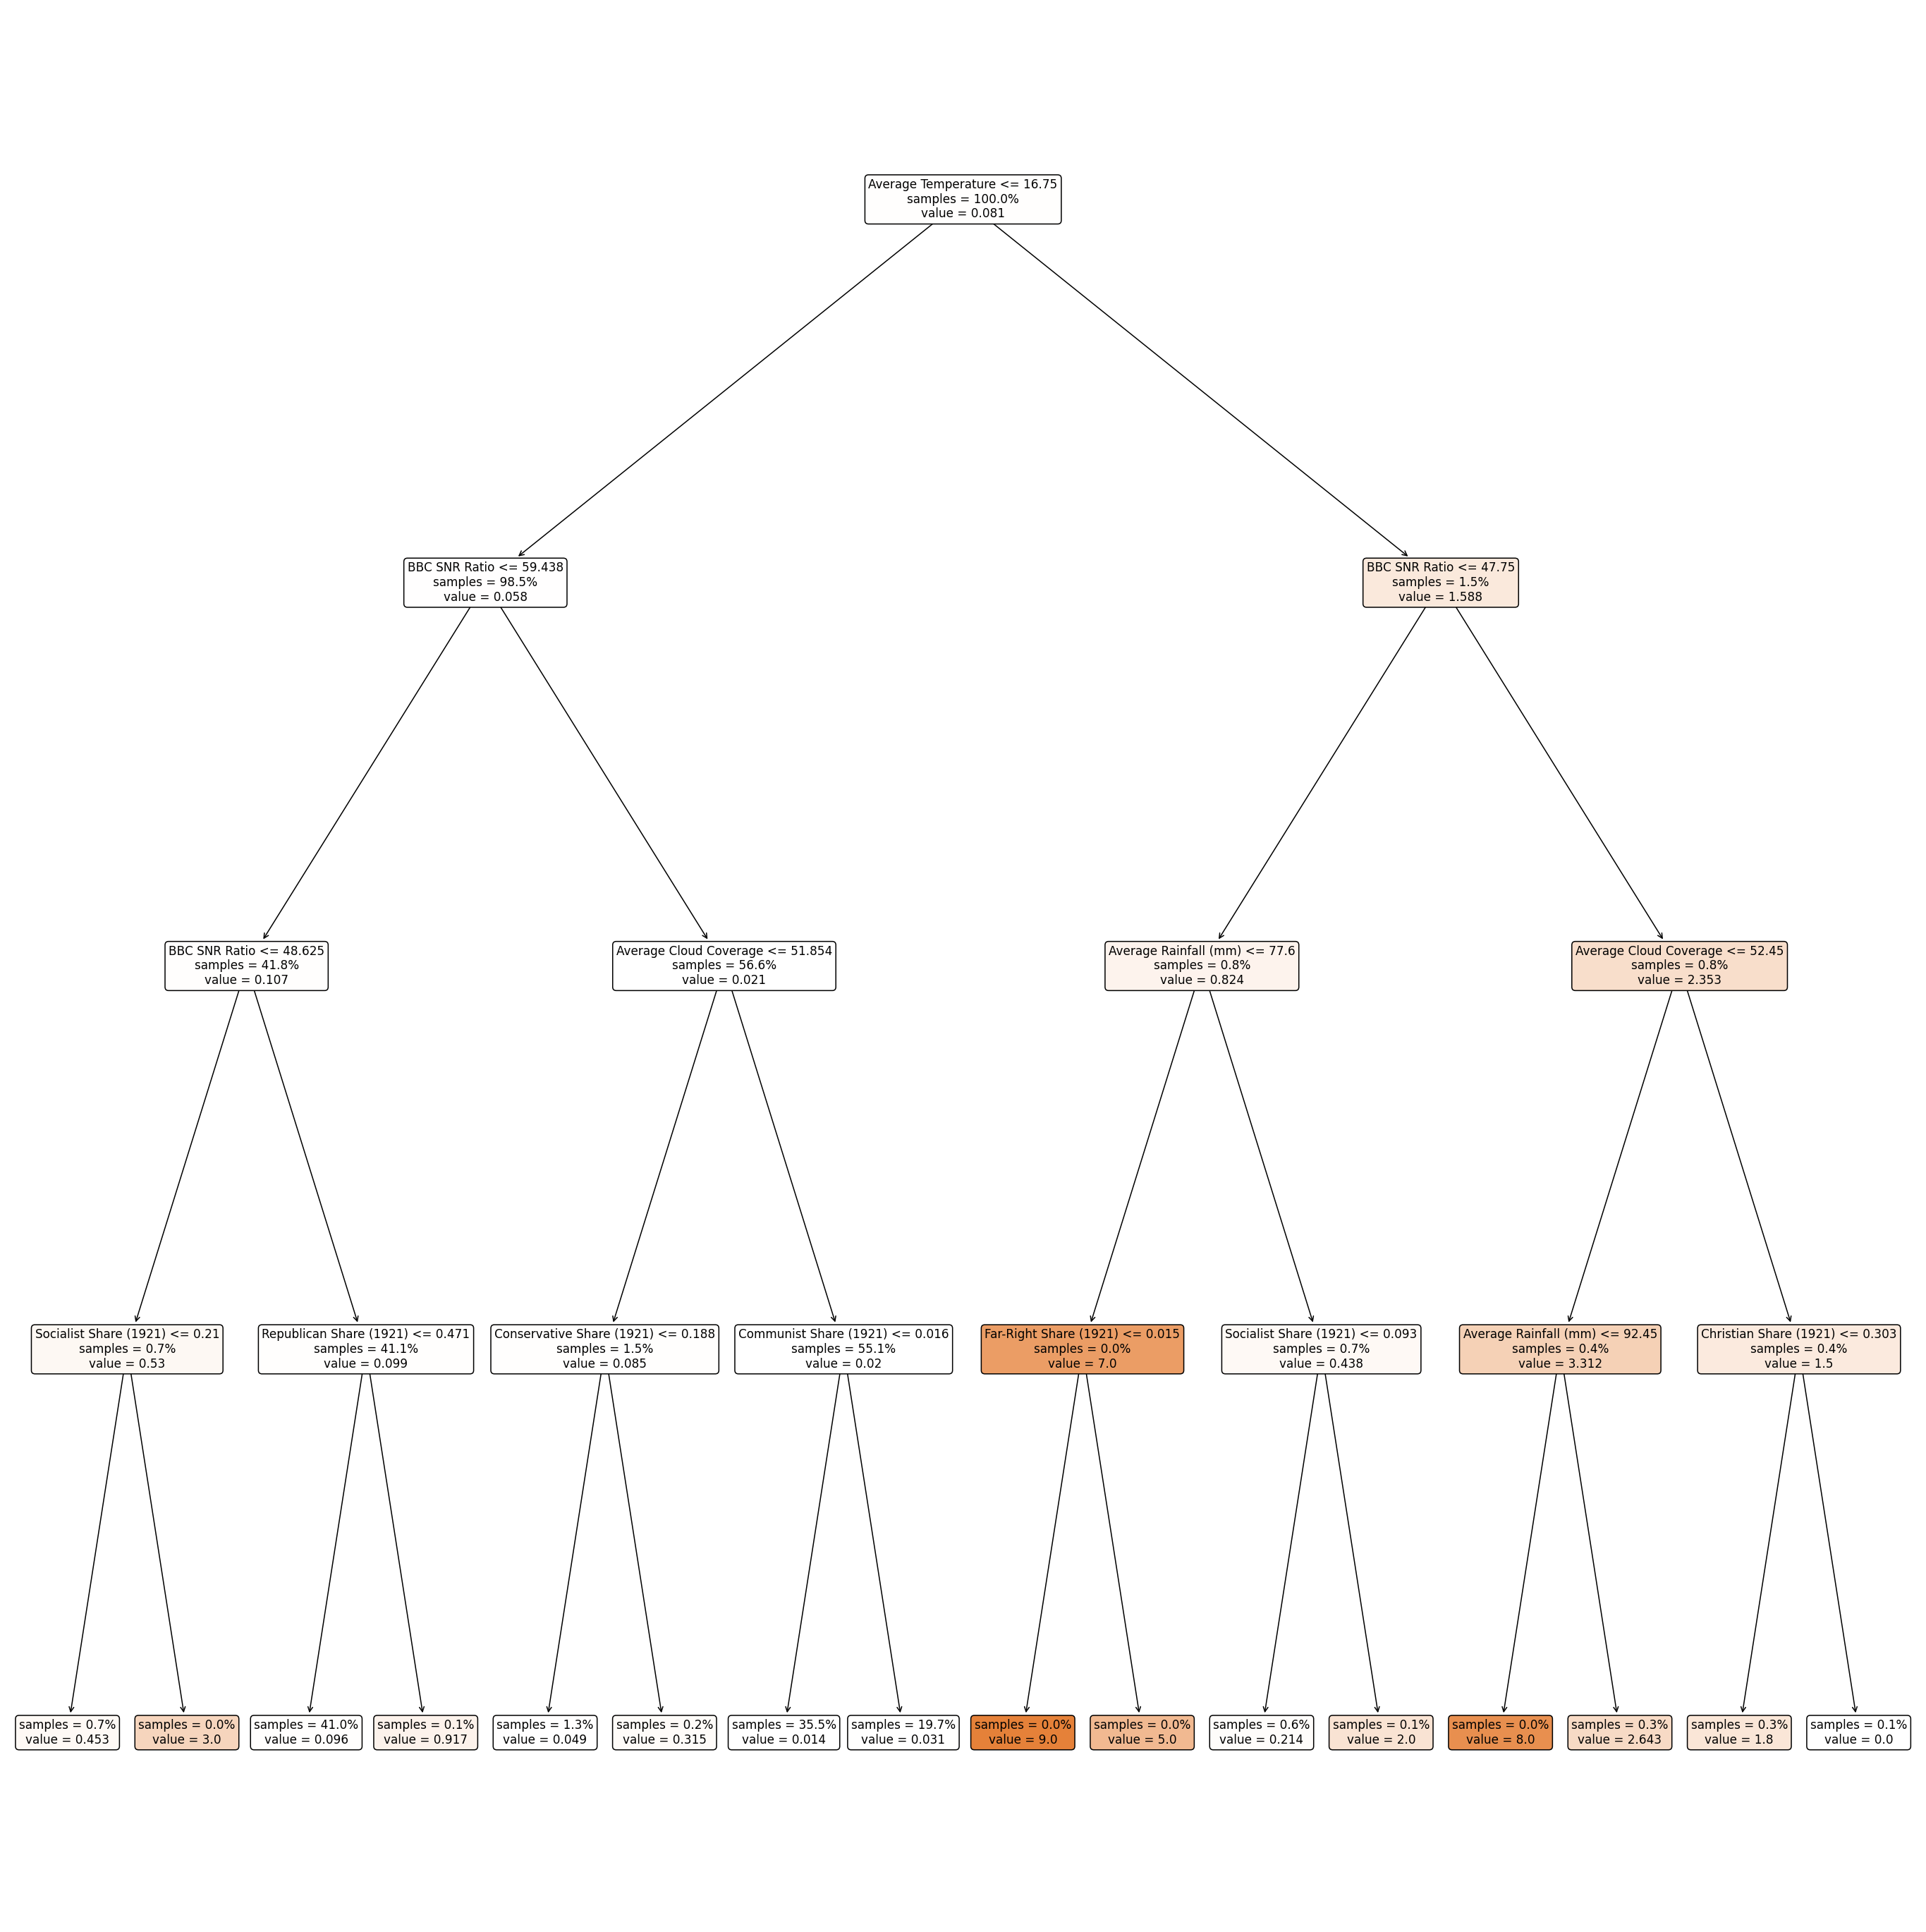

In [47]:
#Figure A.5: Single Decision Tree - 1921
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                collapsed_1921['violence_episode_total'],
                                test_size=0.25,
                                random_state=0)


reg = DTR(max_depth=4)
reg.fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(25, 25), dpi=110)

feature_names = [graph_names_1921.get(name, name) for name in D.columns]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax,
          filled=True, 
         rounded=True,
         proportion=True, 
          impurity=False,
          fontsize=11);
plt.tight_layout()   

In [48]:
#Set up data for Ridge regression and fit the model - 1919
collapsed_1919 = collapsed.loc[:, collapsed.columns.str.contains('|'.join([ 'share_liberal1919', 'share_radical1919', 'share_socialist1919', 'share_republican1919', 'share_conservative1919', 'share_catholic1919', 'share_radical1919', 'avg_cloud_coverage', 'avg_rainfall_millimeter', 
                                                                         'avg_temperature', 'BBC_SNR_Ratio', 
                                                                         'violence_episode_total']))]

design = MS(collapsed_1919.columns.drop('violence_episode_total')).fit(collapsed_1919)
Y = np.array(collapsed_1919['violence_episode_total'])
D = design.fit_transform(collapsed_1919)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

Xs = X - X.mean(0)[None,:]

X_scale = X.std(0)

X_scale_nonzero = np.where(X_scale == 0, 1e-10, X_scale)

Xs = Xs / X_scale_nonzero[None, :]
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs,
                                 Y,
                                 l1_ratio=0.,
                                 alphas=lambdas)[1]
soln_array.shape



/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not conver

(10, 100)

/tmp/ipykernel_70/1145203265.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap("tab20")


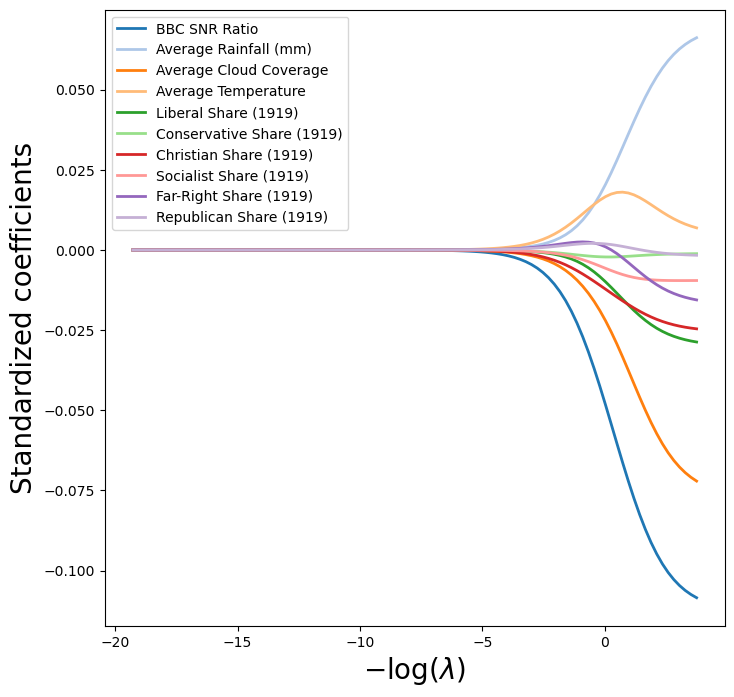

In [49]:
#Figure 6: Ridge Regression Coefficients for 1919
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

soln_path.rename(columns=graph_names_1919, inplace=True)

path_fig, ax = subplots(figsize=(8,8))
colormap = get_cmap("tab20")
for i, column in enumerate(soln_path.columns):
    soln_path[column].plot(ax=ax, color=colormap(i % 20), linewidth=2, label=column)

ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left');

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.337e+02, tolerance: 1.068e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.855e+02, tolerance: 6.411e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

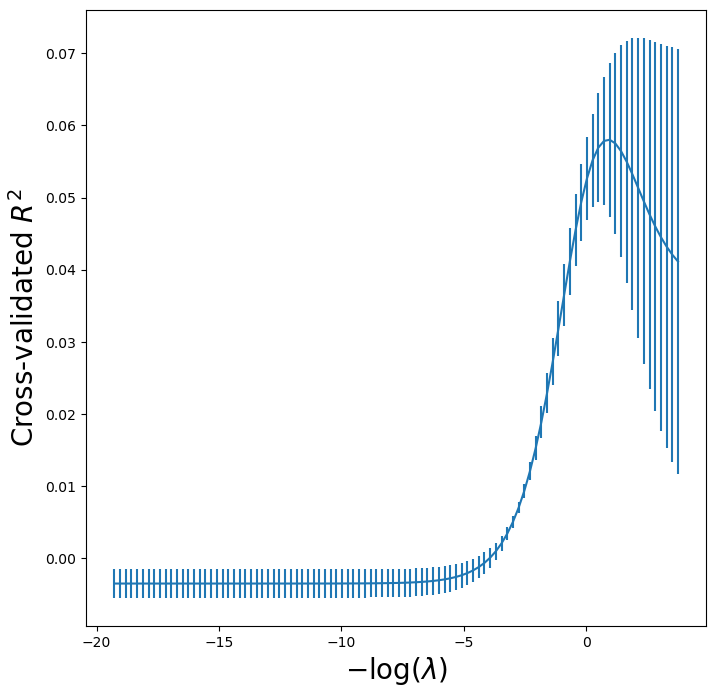

In [50]:
#Figure A.7: Ridge CV Plot for 1919 Elections
beta_hat = soln_path.loc[soln_path.index[39]]
lambdas[39], beta_hat
np.linalg.norm(beta_hat)
beta_hat = soln_path.loc[soln_path.index[59]]
lambdas[59], np.linalg.norm(beta_hat)
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True,  with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=0.5,
                              random_state=0)
ridge.alpha = 0.01
results = skm.cross_validate(ridge,
                             X,
                             Y,
                             scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)
param_grid = {'ridge__alpha': lambdas}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=validation,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_


grid_r2 = skm.GridSearchCV(pipe,
                           param_grid,
                           cv=kfold)
grid_r2.fit(X, Y)

r2_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            grid_r2.cv_results_['mean_test_score'],
            yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated $R^2$', fontsize=20);


/tmp/ipykernel_70/1055300142.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap("tab20")


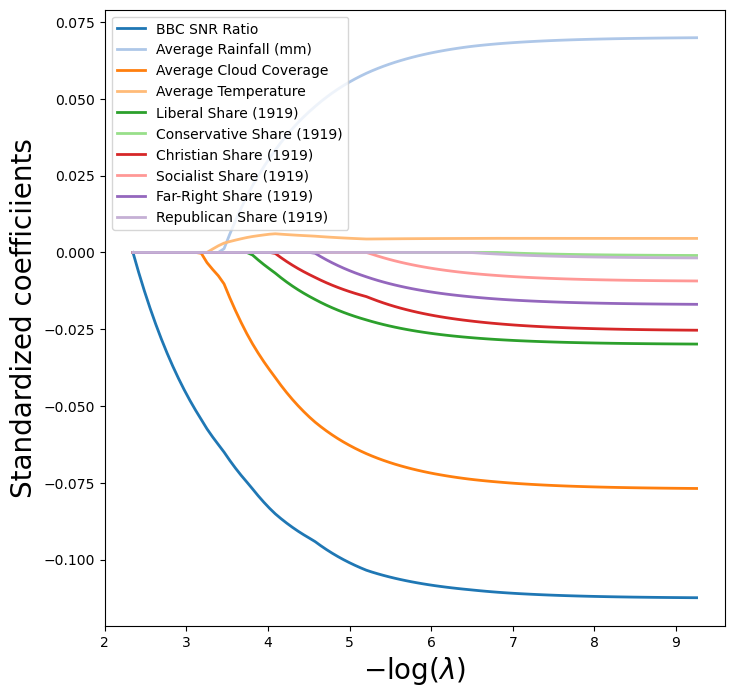

In [51]:
#Figure A.8: Lasso for 1919 elections 
lassoCV = skl.ElasticNetCV(n_alphas=100,
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_
lambdas, soln_array = skl.Lasso.path(Xs,
                                    Y,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

soln_path.rename(columns=graph_names_1919, inplace=True)

path_fig, ax = subplots(figsize=(8,8))
colormap = get_cmap("tab20")
for i, column in enumerate(soln_path.columns):
    soln_path[column].plot(ax=ax, color=colormap(i % 20), linewidth=2, label=column)

ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);


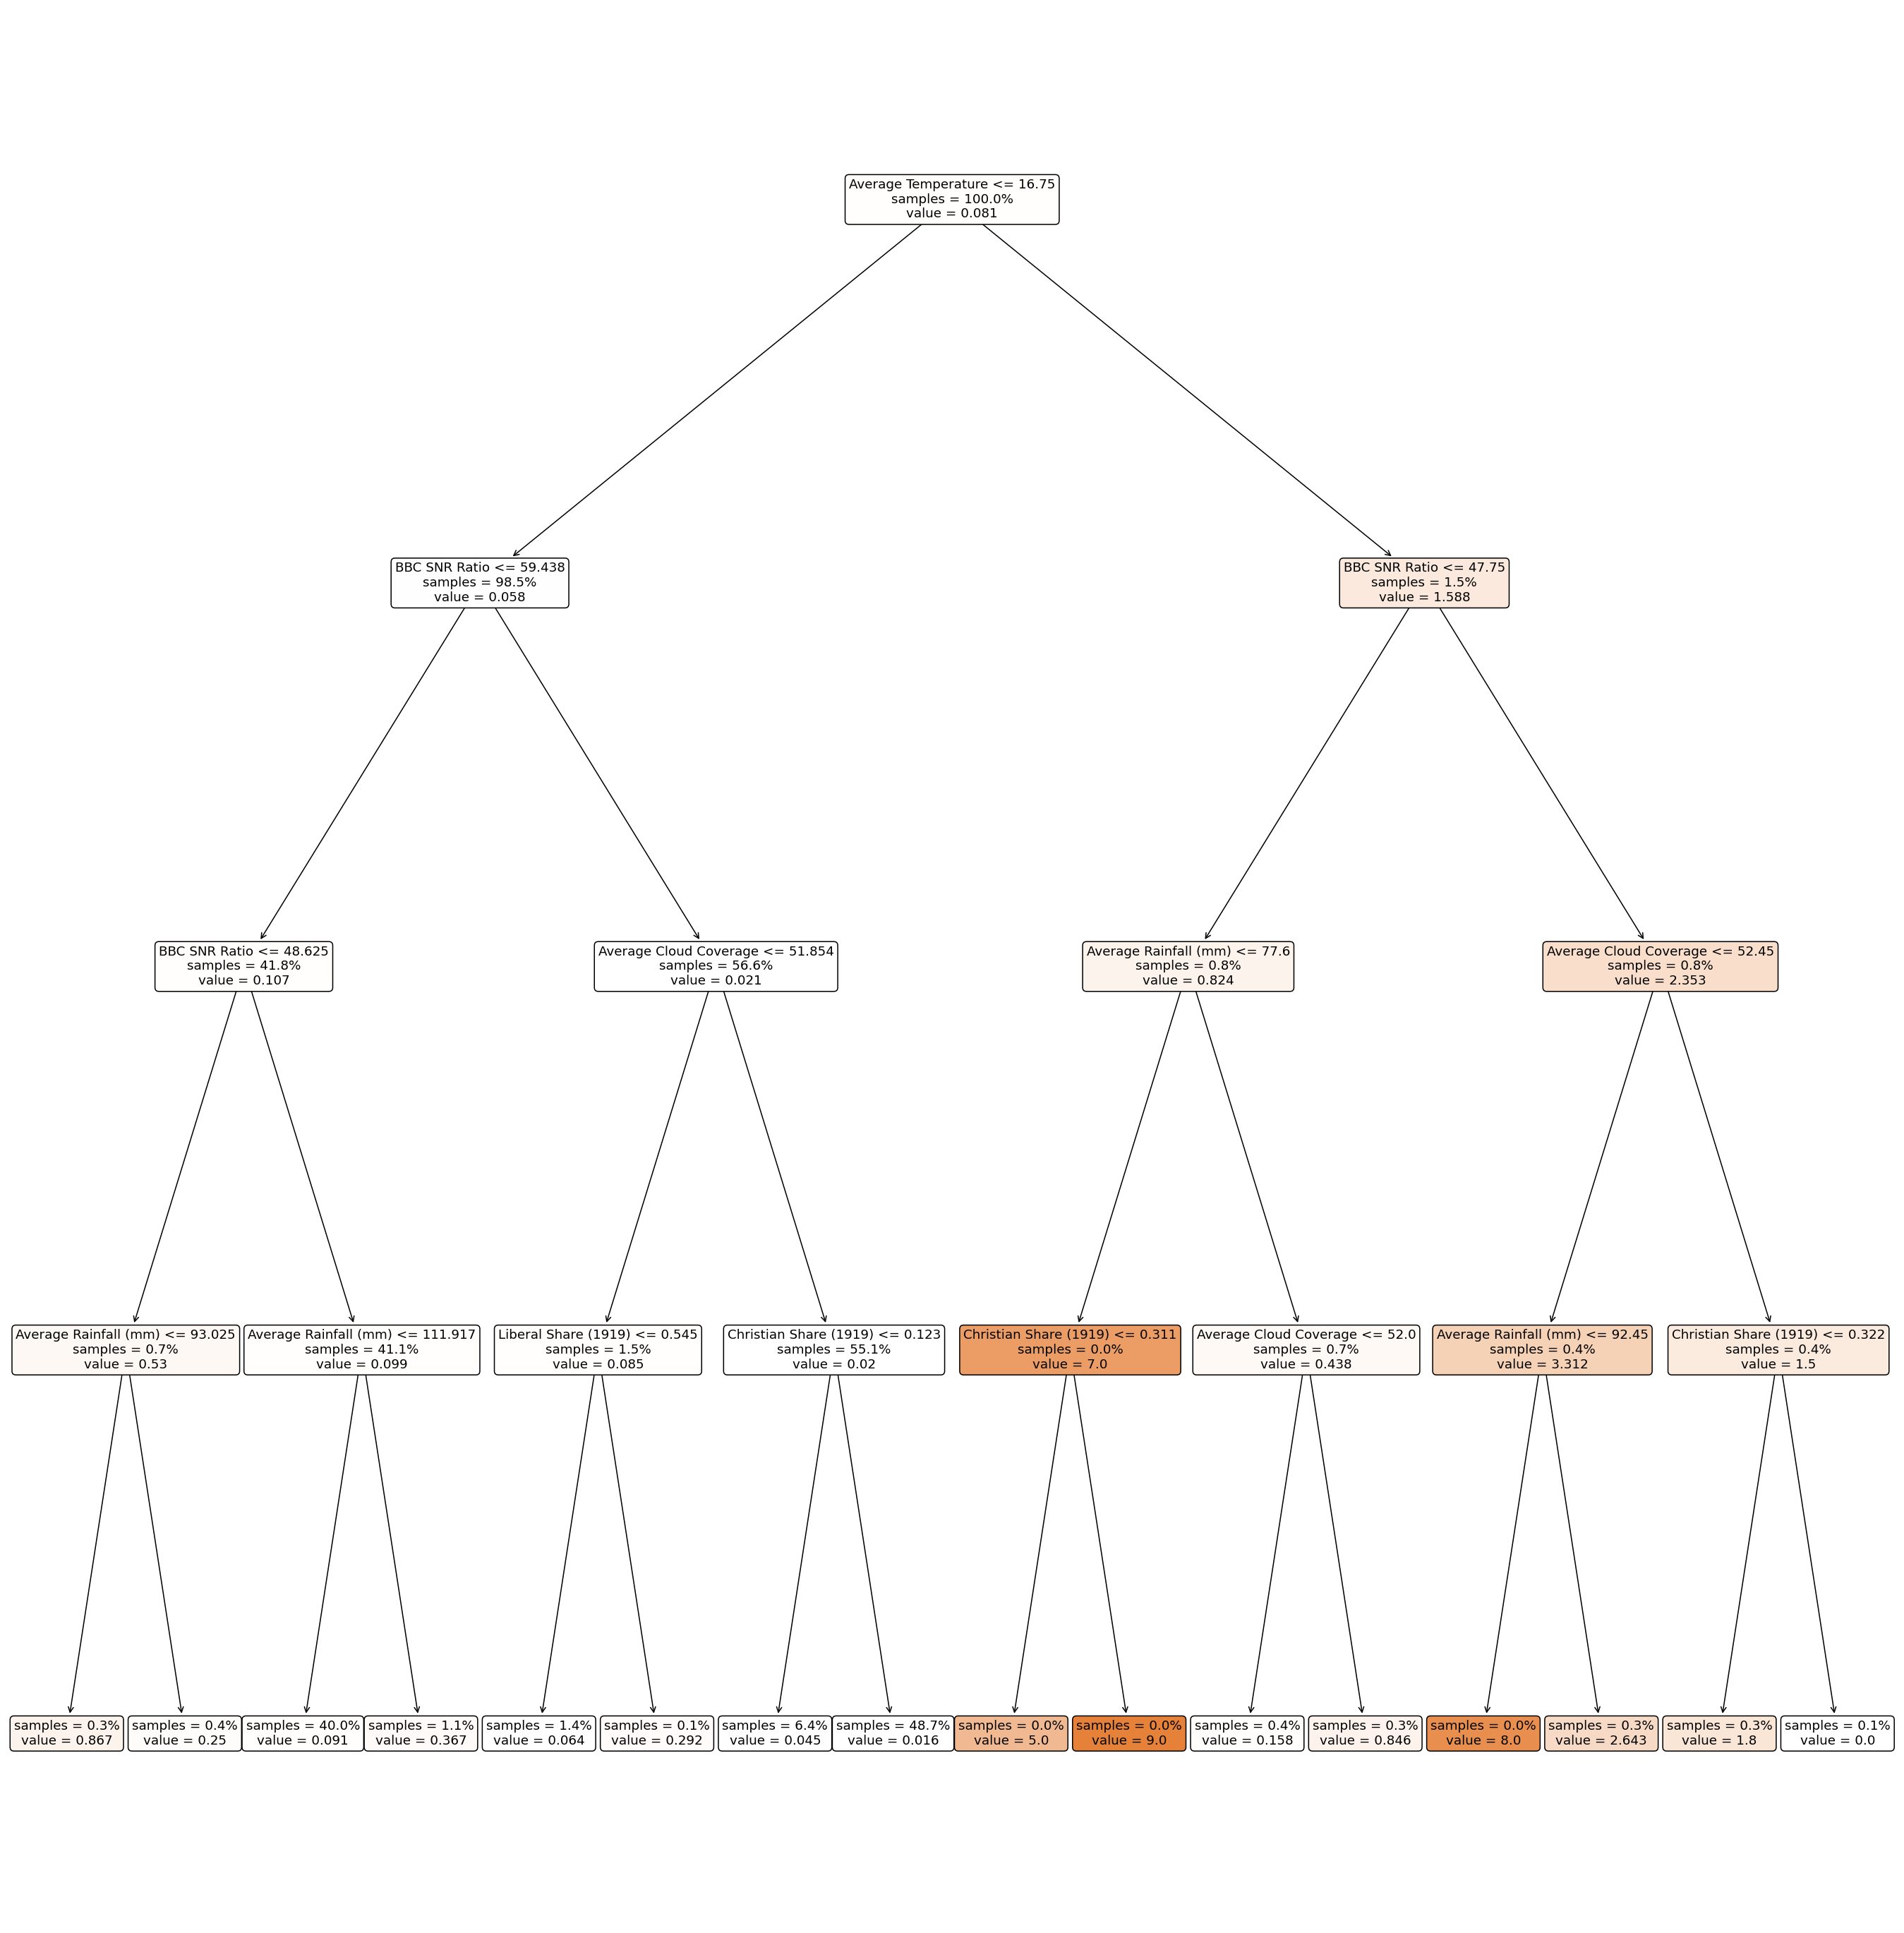

In [52]:
#Figure A.4: Single Decision Tree - 1919
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                collapsed_1919['violence_episode_total'],
                                test_size=0.25,
                                random_state=0)


reg = DTR(max_depth=4)
reg.fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(25, 25), dpi=110)
feature_names = [graph_names_1919.get(name, name) for name in D.columns]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax,
          filled=True, 
         rounded=True,
         proportion=True, 
          impurity=False,
          fontsize=12);
plt.tight_layout()   